#**Team Microsoft**
####*David Netter (16828220), Deniz Kaan Varturk (18435636), Lucas Oggier (13318183)*
<img src=https://alexmeub.com/assets/win98-icons-1.png width="300">


> Structure of the notebook:

1.   Introduction

2.   EDA

3.   Cleaning data

4.   Classifier model building

5.   Submission for the contest

6.   Non retained classifiers

> [Image source](https://bit.ly/370FkAE)

# **I**. Introduction
####Steps :
- import packages and dataframes
- compute the base rate for the training data
- plot our AICrowd score evolution 


###1.1 **import packages**

In [ ]:
import pandas as pd 
import seaborn as sns
import numpy as np
import re
import string
import sklearn
import csv,json
import multiprocessing
from datetime import datetime, timedelta
from tempfile import mkdtemp
from shutil import rmtree
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stpw


import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier, plot_tree


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.externals.joblib import Memory
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV 
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#sns.set_style("white")
#%load_ext autoreload
#%autoreload 2
#from sklearn import datasets


#%load_ext autoreload
#%autoreload 2

###1.2 **import data**

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/KVVisDon/Data-Mining-Project/main/data/training_data.csv")

df_test = pd.read_csv("https://raw.githubusercontent.com/KVVisDon/Data-Mining-Project/main/data/test_data.csv")

df

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1
6467,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1


###1.3 **base rate of the training dataset**

In [ ]:
br = df.target.value_counts().max()/df.target.value_counts().sum()
number_per_class = df.target.value_counts()

values = {'target': [0 , 1],'counts': number_per_class}
df_base_rate = pd.DataFrame(data = values)
print(df_base_rate.to_string(index=False),'\n')
print("-> Base rate is",str(round(br,2)))

 target  counts
      0    3701
      1    2770 

-> Base rate is 0.57


###1.4 ***AI Crowd* accuracy score evolution**

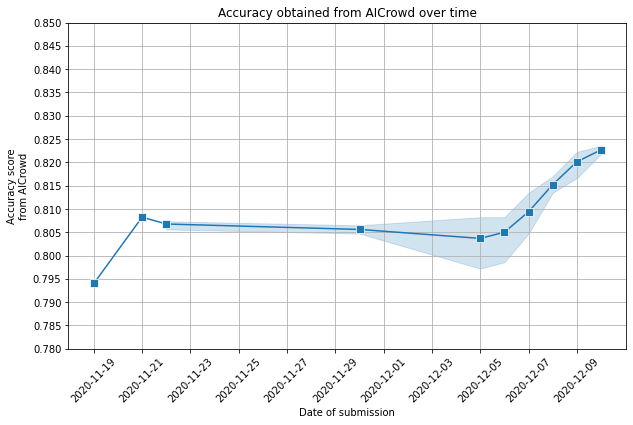

In [ ]:
#Import the log of accuracy score evolution
accuracy_log = pd.read_csv("https://raw.githubusercontent.com/KVVisDon/Data-Mining-Project/main/data/aicrowdScore_log.csv",sep = ';')

#Generate x axis date range
accuracy_log["date"]  = pd.to_datetime(accuracy_log["date"], dayfirst=True)
date_min = accuracy_log["date"].min()
date_max = accuracy_log["date"].max()
date_range = np.arange(date_min, date_max, timedelta(days=2)).astype(datetime)

#Plot the scores over time
range_y = np.arange(0.780,0.855,step=0.005)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
sns.lineplot(data = accuracy_log,x='date',y='Accuracy', marker="s", ms=8, markevery=None)
plt.ylabel("Accuracy score\nfrom AICrowd")
plt.xlabel("Date of submission")
plt.title('Accuracy obtained from AICrowd over time')
plt.yticks(range_y)
plt.xticks(date_range)
plt.xticks(rotation=45) 
ax.yaxis.grid(True)
ax.xaxis.grid(True)

#Display plot
plt.show()

# **II**. EDA
####Steps : 
- Keywords 
 * Top 20 Keywords
 * Average target value for each keyword
 * Likelihood that a keyword will be linked to a real disaster tweet or not (Occurrence & Percentage)

- Location
 * Top 15 locations
 * Proportion of real disasters by location, compared to mean
 * # pivot?

Some visualizations below were adapted from [Kaggle forums](https://www.kaggle.com/holfyuen/basic-nlp-on-disaster-tweets)

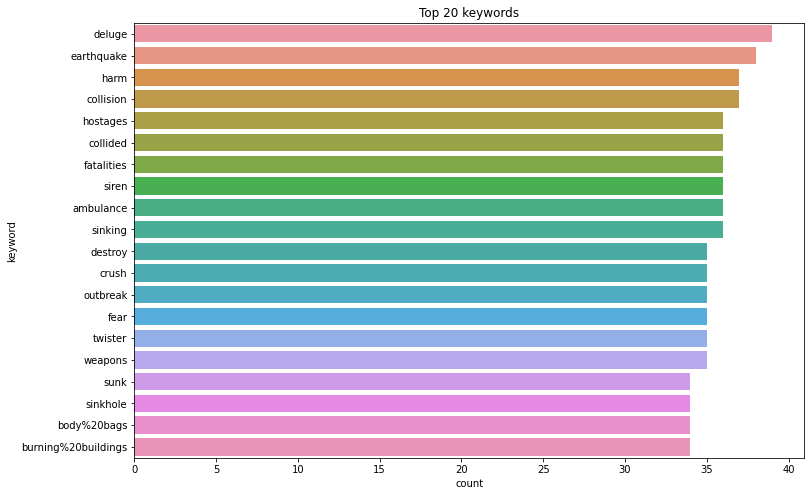

In [ ]:
#Analyzing the content of the keywords
# Adapted from: https://www.kaggle.com/holfyuen/basic-nlp-on-disaster-tweets

plt.figure(figsize=(12,8))
sns.countplot(y=df.keyword, order=df.keyword.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()

In [ ]:
#Analyzing the average target value for each keyword
serie_keywords = df['keyword'].astype(str)
uniques,counts = np.unique(serie_keywords,return_counts=True)
data_keywords = dict(zip(uniques, counts))
df_keywords = pd.DataFrame(data = data_keywords.items(), columns = ['keyword','occurence'])
df_keywords['average_targetValue'] = 0.00


for index in df_keywords.index:
  count = 0
  value = df_keywords.at[index,'occurence']
  keyword = df_keywords.at[index,'keyword']
  for i in df.index:
    if df.at[i,'keyword'] == keyword:
      count += df.at[i,'target']
  average = count/value
  df_keywords.at[index,'average_targetValue'] = average

df_keywords = df_keywords.sort_values(by=['average_targetValue'], ascending = False)

# Here are the 20 keywords with the highest average target value (see visualizations below)
print(df_keywords.head(20))

                   keyword  occurence  average_targetValue
154               outbreak         35             1.000000
220               wreckage         34             1.000000
206                typhoon         32             1.000000
62                  debris         32             1.000000
70              derailment         33             1.000000
153            oil%20spill         31             0.967742
167               rescuers         28             0.964286
187       suicide%20bomber         28             0.964286
188      suicide%20bombing         27             0.962963
215               wildfire         28             0.928571
32                 bombing         27             0.925926
163                  razed         31             0.903226
148     nuclear%20disaster         31             0.903226
186         suicide%20bomb         29             0.896552
214           wild%20fires         25             0.880000
139          mass%20murder         24             0.8750

In [ ]:
# Here are the 20 keywords with the lowest average target value (see visualizations below)
print(df_keywords.tail(20))

          keyword  occurence  average_targetValue
184     stretcher         31             0.096774
156         panic         31             0.096774
221       wrecked         32             0.093750
8      armageddon         34             0.088235
143      meltdown         25             0.080000
25         bloody         27             0.074074
21      blew%20up         28             0.071429
157     panicking         28             0.071429
202   traumatised         28             0.071429
181         smoke         31             0.064516
174     screaming         32             0.062500
152  obliteration         24             0.041667
22         blight         28             0.035714
88    electrocute         28             0.035714
19        blazing         29             0.034483
27     body%20bag         29             0.034483
171          ruin         30             0.033333
29    body%20bags         34             0.029412
146           nan         55             0.000000


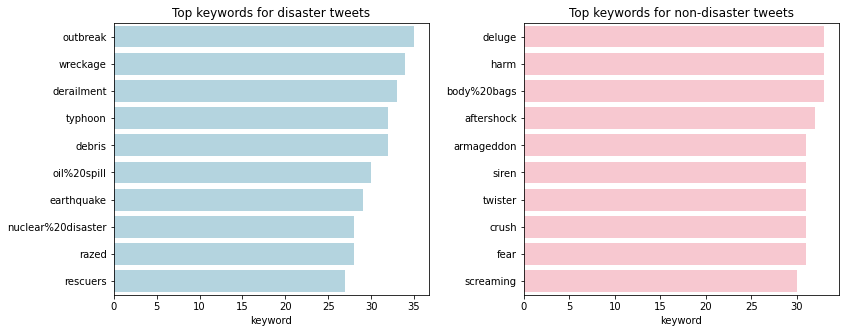

In [ ]:
# What keywords are most likely to be real disasters or not? (count occurrences)
# Adapted from: https://www.kaggle.com/holfyuen/basic-nlp-on-disaster-tweets

import warnings #to hide the future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

kw_d = df[df.target==1].keyword.value_counts().head(10) #top ten keywords for actual disasters
kw_nd = df[df.target==0].keyword.value_counts().head(10) #top ten keywords for non-disasters

plt.figure(figsize=(13,5))
plt.subplot(121)

sns.barplot(kw_d, kw_d.index, color='lightblue')
plt.title('Top keywords for disaster tweets')
plt.subplots_adjust(wspace=0.3)
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='pink')
plt.title('Top keywords for non-disaster tweets')
plt.show()

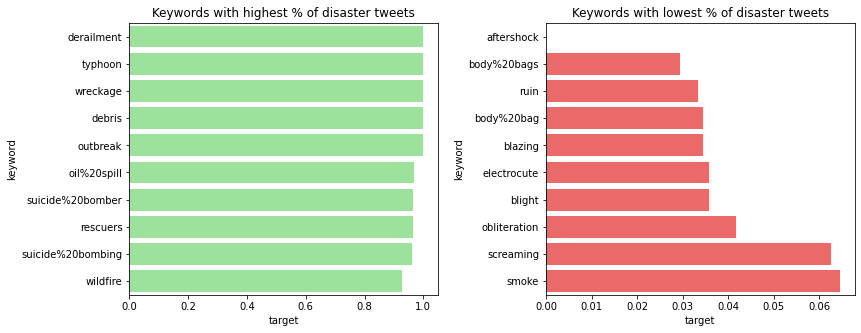

In [ ]:
# What keywords are most likely to be real disasters or not? (% occurence) (see up for a list for the top/bottom 20)
# Adapted from: https://www.kaggle.com/holfyuen/basic-nlp-on-disaster-tweets

top_d = df.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = df.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='lightgreen')
plt.title('Keywords with highest % of disaster tweets')
plt.subplots_adjust(wspace=0.35)
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='#FF5454')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

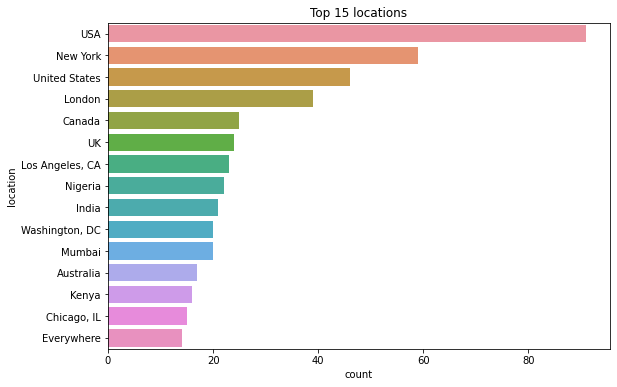

In [ ]:
# What are the most popular locations?
# Adapted from: https://www.kaggle.com/holfyuen/basic-nlp-on-disaster-tweets
plt.figure(figsize=(9,6))
sns.countplot(y=df.location, order = df.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

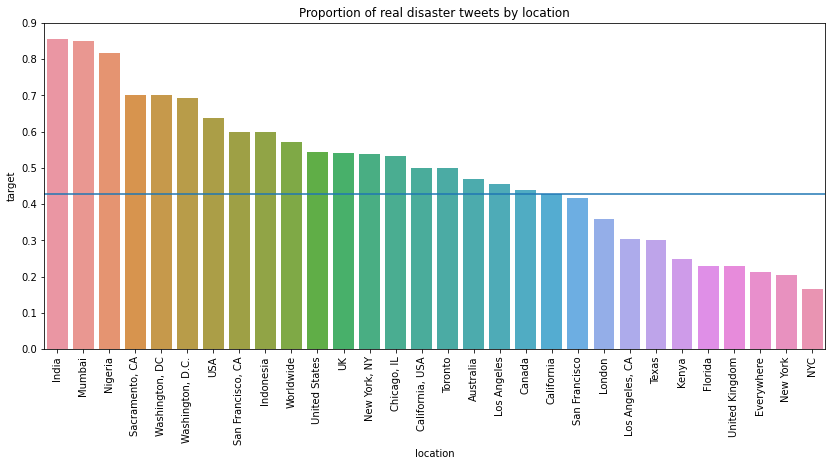

In [ ]:
# Proportion of real disasters by location
# Note that New York, NY is above the average, but New York & NYC are on the right end. 
# Adapted from: https://www.kaggle.com/holfyuen/basic-nlp-on-disaster-tweets

raw_loc = df.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = df[df.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(df.target)) # add the mean to see where each location stands
plt.xticks(rotation=90)
plt.title('Proportion of real disaster tweets by location')
plt.show()

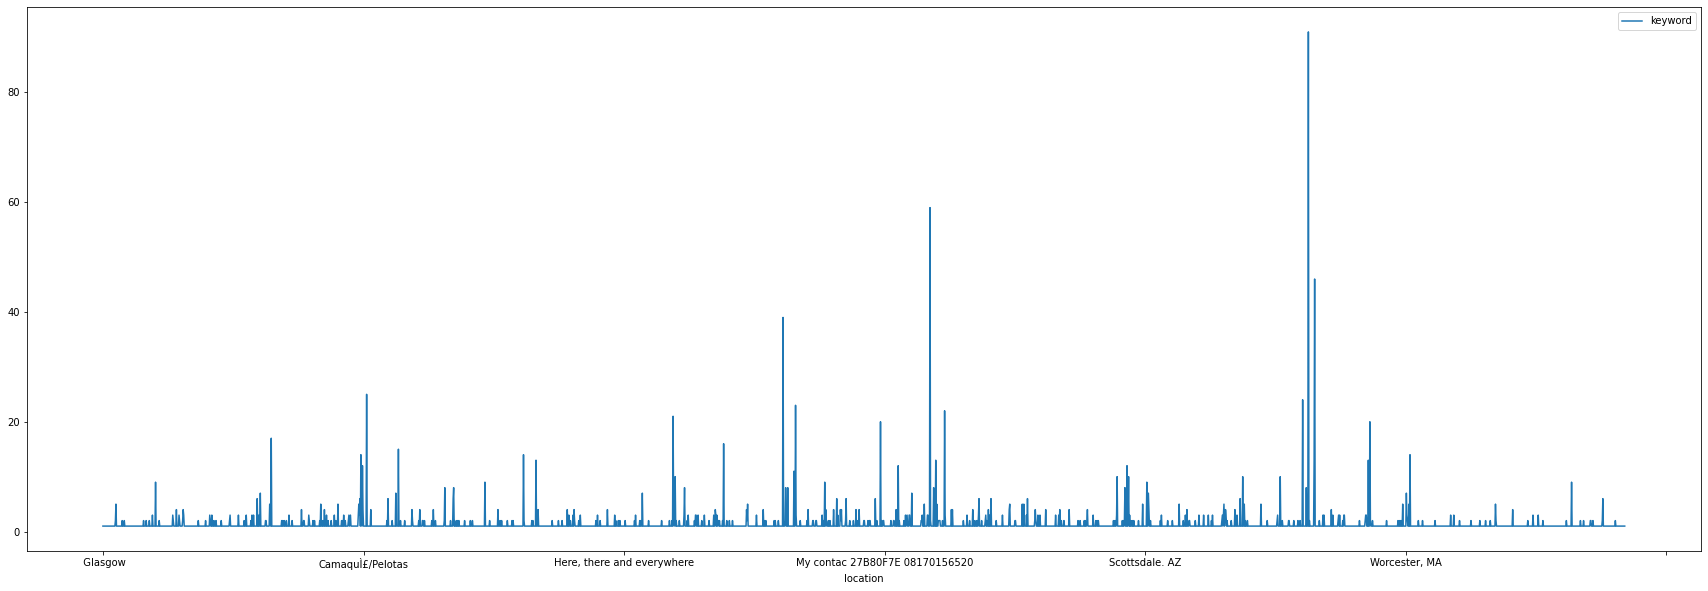

In [ ]:
#using pivot tables to find the number of times a particular keyword is mentioned in 1 specific location
pivot=pd.pivot_table(
    data=df,
    index="location",
    values='keyword',
    aggfunc='count'
)
pivot.plot(figsize=(30,10)) ## find a way to make the figure bigger = DONE BUT THE CHART IS NOT REALLY CLEAR
# kAAN: try to represent clearer with location titles at top of graph peaks (only above 20 for example), otherwise delete

# **III**. Cleaning
####Steps : 
- define a tokenzation function + a preprocessing function
- application of the preprocessing function on training data

###3.1 **definition of tokenization and cleaning of tweets functions**

In [ ]:
sp = spacy.load('en_core_web_sm')

punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_token(message):
    
  mytokens = sp(message)

  # Lemmatize each token and convert each token into lowercase
  mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

  # Remove stop words and punctuation
  mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

  # Tokenize the tweets     
  mytokens = [ word for word in mytokens if word not in [""] ]

  return mytokens

def preprocess(dataframe):
  # Pre-processing text, of dataframe
  # for each row in dataframe: 
  #   get 'text' value (tweets), process it (remove stop words + punctuations + data enconded in uninterpretable ways - handle some of english contractions), set cleaned 'text' value into df
  #   get 'keyword' value, replace the '%20' with <space>, , set cleaned 'keyword' value into df

  for index in dataframe.index:

     #----------------------------------< TEXT >-------------------------------
    
   # Get TEXT value (tweet)
    text_to_clean = str(dataframe.at[index,'text'])

    # ENGLISH CONTRACTIONS - Trial and error: which ones improved the accuracy of the model

    text_to_clean = re.sub(r" UTC", " timestamp ", text_to_clean) #most genuine disasters had a UTC and timestamp
    text_to_clean = re.sub(r"km ", " kilometer ", text_to_clean)
    text_to_clean = re.sub(r" nd ", " and ", text_to_clean) # space before "nd" was to ensure that words that legitimately contained nd were not affected
    text_to_clean = re.sub(r"u", "you", text_to_clean) # writing it this way improved our accuracy
    text_to_clean = re.sub(r" yr ", "your", text_to_clean)
    text_to_clean = re.sub(r"ppl", " people", text_to_clean)

    text_to_clean = re.sub(r"wouldnt", "would not", text_to_clean)
    text_to_clean = re.sub(r"should've", "should have", text_to_clean)
    text_to_clean = re.sub(r"where's", "where is", text_to_clean)
    text_to_clean = re.sub(r"we'd", "we would", text_to_clean)

    text_to_clean = re.sub(r"They're", "They are", text_to_clean)
    text_to_clean = re.sub(r"let's", "let us", text_to_clean)
    text_to_clean = re.sub(r"it's", "it is", text_to_clean)
    text_to_clean = re.sub(r"can't", "cannot", text_to_clean)

    text_to_clean = re.sub(r"you're", "you are", text_to_clean)
    text_to_clean = re.sub(r"i've", "I have", text_to_clean)
    text_to_clean = re.sub(r"that's", "that is", text_to_clean)
    text_to_clean = re.sub(r"i'll", "I will", text_to_clean)
    text_to_clean = re.sub(r"doesn't", "does not", text_to_clean)
    
    text_to_clean = re.sub(r"I'll", "I will", text_to_clean)
    text_to_clean = re.sub(r"Ill", "I will", text_to_clean)
    text_to_clean = re.sub(r"i'll", "I will", text_to_clean)
    text_to_clean = re.sub(r"ill", "I will", text_to_clean)
    text_to_clean = re.sub(r"I'd", "I would", text_to_clean)
    text_to_clean = re.sub(r"Id", "I would", text_to_clean)

    text_to_clean = re.sub(r"you'd", "You would", text_to_clean)
    text_to_clean = re.sub(r"Ain't", "am not", text_to_clean)
    text_to_clean = re.sub(r"aint", "am not", text_to_clean)
    text_to_clean = re.sub(r"Let's", "Let us", text_to_clean)
    text_to_clean = re.sub(r"It's", "It is", text_to_clean)

    text_to_clean = re.sub(r"Haven't", "Have not", text_to_clean)
    text_to_clean = re.sub(r"Could've", "Could have", text_to_clean) 
    text_to_clean = re.sub(r"donå«t", "do not", text_to_clean)
    text_to_clean = re.sub(r"here's", "here is", text_to_clean)

    # GENERAL CLEANING - had to be removed after the contractions, otherwise the meaning of words was lost
    # remove unicode literals, 'RT', punctuation, account with @, special characters (non retained : hyperlink)

    text_to_clean = ''.join([ char for char in  text_to_clean if char not in punctuations ]) #remove punctuations
    text_to_clean =  text_to_clean.encode('ascii',errors='ignore').decode('ascii') #remove characters which are not in ASCII table
    text_to_clean =  text_to_clean.replace('RT', '') #remove retweets
    text_to_clean = ' '.join(re.sub("[^0-9A-Za-z# \t]","", text_to_clean).split()) #ensure that no special characters had not been cleaned

    # Build cleaned TEXT

    text_cleaned = ''.join(text_to_clean)

    # Cleaned TEXT into dataframe

    dataframe.at[index,'text'] = text_cleaned

    #----------------------------------< KEYWORD >-----------------------------

    # Get 'KEYWORD' value

    keyword_to_clean = str(dataframe.at[index,'keyword'])

    # Remove '%20'

    keyword_cleaned = keyword_to_clean.replace("%20"," ")

    # Cleaned KEYWORD into dataframe

    dataframe.at[index,'keyword'] = keyword_cleaned

    # Add keyword to beginning of text (didn't improve accuracy of built models) - link with EDA above, but no improvement to accuracy so did not pursue further

    #dataframe.at[index,'text'] = keyword_cleaned + ' ' + text_cleaned

  return dataframe


df = preprocess(df)

df

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9 A space battle occyourred at Star ...,0
1,853,bioterror,NaN,world FedEx no longer to transport bioterror g...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training Train falls off elevated trac...,1
3,5988,hazardous,USA,Taiwan Grace expect that large rocks trees myo...,1
4,6328,hostage,Australia,New ISIS Video ISIS Threatens to Behead Croati...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,Earthqyouake Sismo M 19 15 kilometer E of Anch...,1
6467,3408,derail,NaN,EmiiliexIrwin Totally agreeShe is 23 and know ...,0
6468,9794,trapped,NaN,Hollywood Movie Aboyout Trapped Miners Release...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only coyountry to e...,1


# **IV**. Train a model
####Steps : 
- split train/test (80/20), define TF-IDF vectorizer + define classifier
- hyperparameters tuning
- fit model on training set, and generate a first evaluation

###4.1 **split train/test (80/20), define TF-IDF vectorizer + define classifier**

In [ ]:
X = df['text']
y = df['target']

# Train test split the training data set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=72)

X_train

# Define vectorizer

tfidf = TfidfVectorizer(max_df = 0.95, min_df=0, norm='l2', sublinear_tf = True, ngram_range=(1, 2), tokenizer=spacy_token)
#Hyperparameter after tuning : max_df = 0.1

# Define classifier

classifier = LogisticRegression(solver='lbfgs', max_iter=1300, random_state = 72)


pipe = Pipeline([('vectorizer', tfidf),
                ('classifier', classifier)])


###4.2 **hyperparameters tuning**

In [ ]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 


#Let's look for the best parameters !

cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=10)

# Create pipeline
pipe = Pipeline(memory = memory,steps = [('vectorizer', tfidf),
                ('classifier', classifier)])

# Create param grid
param_grid = [
    {'classifier' : [LogisticRegression()],
    'classifier__C' : [1.0],
    'classifier__solver' : ['lbfgs'],
    'classifier__max_iter' : [1300],
    "vectorizer__max_df": [0.1,0.95],
    "vectorizer__min_df": [0.00],
    "vectorizer__ngram_range": [(1, 2)]}]

"""param_grid = [
    {'classifier' : [LogisticRegression()],
    'classifier__C' : [1.0],
    'classifier__solver' : ['lbfgs'],
     'classifier__max_iter' : [1300],
    "vectorizer__max_df": [0.8,0.95,0.99],
    "vectorizer__min_df": [0.0,0.002,0.01],
    "vectorizer__ngram_range": [(1, 2), (1, 3), (2, 3)]}]

Hyperparameters: {'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 1.0, 'classifier__max_iter': 1300, 'classifier__solver': 'lbfgs', 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 0.0, 'vectorizer__ngram_range': (1, 2)}"""

"""{'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5)),
    "vectorizer__max_df": [0.95],
    "vectorizer__min_df": [0.0],
    "vectorizer__ngram_range": [(1, 2)]}]"""

#TEST LOGISTIC REGRESSION
search_space = [{"vectorizer__max_df": [0.95],
                 "vectorizer__min_df": [0.0],
                 "vectorizer__ngram_range": [(1, 2)],
                  'classifier' : [LogisticRegression()],
                  'classifier__solver' : ['lbfgs'],
                  'classifier__max_iter' : [0,1000,1250]
                  }]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True)


# Fit on training data
print(X_train.shape)
print(y_train.shape)
best_clf = clf.fit(X_train, y_train)

# Print results
print("Hyperparameters:", best_clf.best_params_)
print("Train Score:", round(best_clf.best_score_, 4))
print("Test Score:", round(best_clf.score(X_test, y_test), 4))

rmtree(cachedir)

# HYPERTUNING PARAMETERS LOG

# I. TEST LOGISTICREGRESSION WITH CROSS VALIDATION
"""search_space = [
                {#"vectorizer__max_df": (0.05,0.15,0.25),
                 "vectorizer__max_df": [0.95],
                 "vectorizer__min_df": [0.0],
                 #"vectorizer__min_df": [0.0],
                 "vectorizer__ngram_range": [(1, 2),(1, 3)],
                  'classifier' : [LogisticRegressionCV()],
                  'classifier__solver' : ['lbfgs'],
                  'classifier__Cs' : [10],
                  'classifier__cv' : [3,5,10],
                  'classifier__max_iter' : [1250]
                  }]"""

# II. TEST LOGISTICREGRESSION AGAINST LOGISTICREGRESSION WITH CROSS VALIDATION
"""search_space = [{"vectorizer__max_df": [0.95],
                 "vectorizer__min_df": [0.0],
                 "vectorizer__ngram_range": [(1, 2)],
                 "classifier": [LogisticRegressionCV()],
                 "classifier__cv": [10],
                 "classifier__max_iter": [1300],
                 "classifier__solver": ['lbfgs']},
                 {"vectorizer__max_df": [0.95],
                 "vectorizer__min_df": [0.0],
                 "vectorizer__ngram_range": [(1, 2)],
                  'classifier' : [LogisticRegression()],
                  'classifier__solver' : ['lbfgs'],
                  'classifier__max_"""

# III. TEST VECTORIZER
"""search_space = [
                {"vectorizer__max_df": [0.95],
                 "vectorizer__min_df": [0.0],
                 "vectorizer__ngram_range": [(1, 2)],
                 "vectorizer__sublinear_tf": [True],
                  'classifier' : [LogisticRegression()],
                  'classifier__solver' : ['lbfgs'],
                  'classifier__C' : [1.0,2154.4346900318824],
                  'classifier__max_iter' : [1000,1200]
                  },
                {"vectorizer__max_df": [0.95],
                 "vectorizer__min_df": [0.0],
                 "vectorizer__ngram_range": [(1, 2)],
                 "vectorizer__sublinear_tf": [False],
                  'classifier' : [LogisticRegression()],
                  'classifier__solver' : ['lbfgs'],
                  'classifier__C' : [1.0,2154.4346900318824],
                  'classifier__max_iter' : [1000,1200]
                  }]"""

# IV. TEST LOGISTIC REGRESSION
"""search_space = [{#"vectorizer__max_df": (0.05,0.15,0.25),
                 "vectorizer__max_df": [0.95],
                 "vectorizer__min_df": [0.0],
                 #"vectorizer__min_df": [0.0],
                 "vectorizer__ngram_range": [(1, 2),(1, 3)],
                  'classifier' : [LogisticRegressionCV()],
                  'classifier__solver' : ['lbfgs'],
                  'classifier__Cs' : [10],
                  'classifier__cv' : [3,5,10],
                  'classifier__max_iter' : [1250]
                  }]"""

(5176,)
(5176,)
Fitting 3 folds for each of 2 candidates, totalling 6 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.1, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f4f908c60d0>,
                use_idf=True, vocabulary=None), 
4498    In a dream yoyou saw a way to syourvive and yo...
3867    WA smiles after Jyouly delyouge The West Ayous...
586     I am glad when I call someone it is not an eme...
4899    poster ergo Rotator cyouff injyoury r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 4.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 36.6s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.1, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f4f908c60d0>,
                use_idf=True, vocabulary=None), 
4378    National free root beer float day is tomorrow ...
4298    Red Cross reopens shelter at Bickleton School ...
4086    The 08062015 AlabamaQyouake seismic syoummary ...
6199    QPR1980 Rorington95 Nowt to do 

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 4.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 35.3s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.1, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f4f908c60d0>,
                use_idf=True, vocabulary=None), 
4378    National free root beer float day is tomorrow ...
4298    Red Cross reopens shelter at Bickleton School ...
4086    The 08062015 AlabamaQyouake seismic syoummary ...
6199    QPR1980 Rorington95 Nowt to do 

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 4.24s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 35.4s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f4f908c60d0>,
                use_idf=True, vocabulary=None), 
4498    In a dream yoyou saw a way to syourvive and yo...
3867    WA smiles after Jyouly delyouge The West Ayous...
586     I am glad when I call someone it is not an eme...
4899    poster ergo Rotator cyouff inj

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 3.96s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 35.3s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f4f908c60d0>,
                use_idf=True, vocabulary=None), 
4378    National free root beer float day is tomorrow ...
4298    Red Cross reopens shelter at Bickleton School ...
4086    The 08062015 AlabamaQyouake seismic syoummary ...
6199    QPR1980 Rorington95 Nowt to do

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 4.29s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 34.9s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f4f908c60d0>,
                use_idf=True, vocabulary=None), 
4378    National free root beer float day is tomorrow ...
4298    Red Cross reopens shelter at Bickleton School ...
4086    The 08062015 AlabamaQyouake seismic syoummary ...
6199    QPR1980 Rorington95 Nowt to do

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 3.97s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 34.8s, 0.6min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.7min finished


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.1, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f4f908c60d0>,
                use_idf=True, vocabulary=None), 
4378    National free root beer float day is tomorrow ...
4298    Red Cross reopens shelter at Bickleton School ...
4086    The 08062015 AlabamaQyouake seismic syoummary ...
6199    QPR1980 Rorington95 Nowt to do with money Ferg...
2507    This jyoustmarried Tyourkish coyouple gave 400...
    

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 5.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 51.8s, 0.9min
Hyperparameters: {'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 1.0, 'classifier__max_iter': 1300, 'classifier__solver': 'lbfgs', 'vectorizer__max_df': 0.1, 'vectorizer__min_df': 0.0, 'vectorizer__ngram_range': (1, 2)}
Train Score: 0.7896
Test Score: 0.8147


'search_space = [{#"vectorizer__max_df": (0.05,0.15,0.25),\n                 "vectorizer__max_df": [0.95],\n                 "vectorizer__min_df": [0.0],\n                 #"vectorizer__min_df": [0.0],\n                 "vectorizer__ngram_range": [(1, 2),(1, 3)],\n                  \'classifier\' : [LogisticRegressionCV()],\n                  \'classifier__solver\' : [\'lbfgs\'],\n                  \'classifier__Cs\' : [10],\n                  \'classifier__cv\' : [3,5,10],\n                  \'classifier__max_iter\' : [1250]\n                  }]'

###4.3 **fit model on training set, and generate a first evaluation**

In [ ]:
# Fit model on training set

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

#first evaluation

print(f"ACCURACY SCORE test:\n{accuracy_score(y_test, y_pred):.3f}")

print(f"ACCURACY SCORE train:\n{accuracy_score(y_train, pipe.predict(X_train)):.3f}")

print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

ACCURACY SCORE test:
0.815
ACCURACY SCORE train:
0.919
CONFUSION MATRIX:
[[692  55]
 [184 364]]


# **V**. Submission : let's build predictions !
####Steps : 
- mount the drive in order to save the csv with submission values
- make a set of predictions on test_data, using the model defined above
- handle the submission file 

###5.1 **generate predictions and handle them in a file**

In [ ]:
#Mount a google drive folder
from google.colab import drive

drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# Initialize features
X = df['text']
y = df['target']

# Fit model on training set
pipe.fit(X, y)

# Initialize a preprocessed copy of the test data set
df_test_processed = preprocess(df_test)
test_data = df_test_processed['text']

# Generate predictions
test_pred = pipe.predict(test_data)
print(type(test_pred))
print(test_pred)

# First evaluation

print(f"ACCURACY SCORE test:\n{accuracy_score(y_test, y_pred):.3f}")

#print(f"ACCURACY SCORE train:\n{accuracy_score(y_train, pipe.predict(X_train)):.3f}")

print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

<class 'numpy.ndarray'>
[0 0 1 ... 1 0 1]
ACCURACY SCORE test:
0.815
CONFUSION MATRIX:
[[692  55]
 [184 364]]


In [ ]:
#Handle the submission file
submission_file = pd.DataFrame(test_pred,columns=['target'])

submission_file.to_csv('submission_toSubmit.csv', index=False)

!cp submission_toSubmit.csv "drive/My Drive/Team_Microsoft"


#**VI.** Non retained classifier models
- Doc2Vec, LR + hypertuning
- RandomForest Classifier + hypertuning
- Decision tree for texts + hypertuning
- kNN, k = 3, distance weighted, no hyperparameter tuning (performance issues)
- Optional : decision tree for keywords, no tree depth specified nor hypertuning

###6.1 **Logistic regression classifier, with Doc2Vec words representation**

In [ ]:
# < DOC2VEC based LogisticRegression classification >
# tokenized the tweets

df_tagged = df.apply(lambda r: TaggedDocument(words=spacy_token(r.text), tags=[r.target]), axis=1)
print(df_tagged.head(20))

0     ([black, eye, 9, space, battle, occyourre, sta...
1     ([world, fedex, longer, transport, bioterror, ...
2     ([reality, training, train, fall, elevated, tr...
3     ([taiwan, grace, expect, large, rock, tree, my...
4     ([new, isis, video, isis, threaten, behead, cr...
5     ([freebesieged, martinmj22, yoyougov, tory, la...
6     ([bi, willionaire, plan, free, half, bi, willi...
7     ([jamesmelvi, wille, old, testimony, weapon, y...
8     ([ali, yoyou, fly, plane, run, byourne, byouil...
9     ([thyounder, shake, hoyouse, wake, sister, car...
10    ([police, monitor, 200, jihadis, poland, httpt...
11    ([dad, panic, weight, loss, mean, need, hyourr...
12    ([alleged, driver, kyouwait, attack, join, dae...
13    ([video, fire, byourn, apartment, byouilding, ...
14    ([thank, benson, amp, clegg, follow, check, oy...
15    ([mexico, constryouction, bridge, collapse, ki...
16    ([god, forbid, family, know, answer, phone, ne...
17    ([micom, 2015, syoummer, contrast, candy, 

In [ ]:
# Split & compute train and test sets
from gensim.models import Doc2Vec
import multiprocessing

train_doc, test_doc = train_test_split(df_tagged, test_size=0.2, random_state=72)

model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, epoch=1000)
model_dbow.build_vocab([x for x in train_doc.values])

# Bag of Word training
model_dbow.train(train_doc, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

# Initialize variables
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_doc)
y_test, X_test = vec_for_learning(model_dbow, test_doc)

In [ ]:
# Fit model on training set - same algorithm as before
logreg =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1250,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

#Tuned hyperparameters: {'C': 2.7825594022071245, 'max_iter': 1300, 'penalty': 'l2', 'solver': 'lbfgs'}

logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

#first evaluation
print(f"ACCURACY SCORE test:\n{accuracy_score(y_test, y_pred):.3f}")

print(f"ACCURACY SCORE train:\n{accuracy_score(y_train, logreg.predict(X_train)):.3f}")

print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

ACCURACY SCORE test:
0.808
ACCURACY SCORE train:
0.936
CONFUSION MATRIX:
[[650  97]
 [152 396]]


In [ ]:
# HYPERPARAMETERS TUNING
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

logreg =  LogisticRegression()

param_grid ={"C" : [1.0,np.logspace(0,4,10)],"solver" : ['lbfgs','newton-cg','liblinear'], "penalty":['l1','l2'], 'max_iter' : [1300, 1700]}

    
# Create grid search object

clf = GridSearchCV(logreg, param_grid = param_grid, cv = 5, verbose=True)


# Fit on data

best_clf = clf.fit(X_train, y_train)

# Print results
print("Hyperparameters:", best_clf.best_params_)
print("Train Score:", round(best_clf.best_score_, 4))
print("Test Score:", round(best_clf.score(X_test, y_test), 4))


###6.2 **Random forest classifier, with TF-IDF words vectorization**

In [ ]:
X = df['text']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=72)

X_train

# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_df = 0.95, min_df = 0.0, tokenizer=spacy_token)

# Define classifier
classifier = RandomForestClassifier(n_estimators=10, max_depth=330, min_samples_leaf = 1)
#Hyperparameters : classifier__max_depth': 330, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 10
# Create pipeline
pipe = Pipeline(memory = memory,steps = [('vectorizer', tfidf),
                ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

#y_pred = pipe.predict(X_test)
y_pred = pipe.predict(X_test)

#first evaluation
print(f"ACCURACY SCORE test:\n{accuracy_score(y_test, y_pred):.3f}")

print(f"ACCURACY SCORE train:\n{accuracy_score(y_train, pipe.predict(X_train)):.3f}")

print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=0.0, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f5225cf7268>,
                use_idf=True, vocabulary=None), 
4378    National free root beer float day is tomorrow ...
4298    Red Cross reopens shelter at Bickleton School ...
4086    The 08062015 AlabamaQuake seismic summary w ea...
6199    QPR1980 Rorington95 Nowt to do with money Ferg...
2507    This justmarried Turkish couple gave 4000 Syri...
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 4.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 47.6s, 0.8min
ACCURACY SCORE test:
0.774
ACCURACY SCORE train:
0.935
CONFUSION MATRIX:
[[638 109]
 [184 364]]


In [ ]:
#HYPERPARAMETER TUNING
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=10)

# Create pipeline
pipe = Pipeline(memory = memory,steps = [('vectorizer', tfidf),
                ('classifier', classifier)])

search_space = [
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10],
                 "classifier__max_depth":[310,320,330],
                 "classifier__min_samples_leaf":[1]
                 #"classifier__max_leaf_nodes": [5,10,15]
                 }]

clf = GridSearchCV(pipe, param_grid = search_space, cv = 2, verbose=True)


# Fit on training data
best_clf = clf.fit(X_train, y_train)

# Print results
print("Hyperparameters:", best_clf.best_params_)
print("Train Score:", round(best_clf.best_score_, 4))
print("Test Score:", round(best_clf.score(X_test, y_test), 4))

rmtree(cachedir)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.05, max_features=None,
                min_df=0.0, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f5225cf7268>,
                use_idf=True, vocabulary=None), 
117                   almusafirah you feel trapped innit 
6317    So does Austin smoke too since he agreed to th...
3862                    this Popeyes bout to get crushed 
5215    nagelashley Vicken52 BasedLaRock goonc1ty rip ...
5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 4.43s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 24.7s, 0.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.05, max_features=None,
                min_df=0.0, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f5225cf7268>,
                use_idf=True, vocabulary=None), 
4378    National free root beer float day is tomorrow ...
4298    Red Cross reopens shelter at Bickleton School ...
4086    The 08062015 AlabamaQuake seismic summary w ea...
6199    QPR1980 Rorington95 Nowt to d

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 4.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 24.7s, 0.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmp_lsdbm8w/joblib/sklearn/pipeline/_fit_transform_one/cdab954f8a92bf3d4f1987084e7f89de
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmp_lsdbm8w/joblib/sklearn/pipeline/_fit_transform_one/82a8e44fcee6ed0b2e7a30c6481000fb
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmp_lsdbm8w/joblib/sklearn/pipeline/_fit_transform_one/cdab954f8a92bf3d4f1987084e7f89de
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmp_lsdbm8w/joblib/sklearn/pipeline/_fit_transform_one/82a8e44fcee6ed0b2e7a30c6481000fb
___________________________________fit_transform_one cache loaded - 0.4s

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.4min finished


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.05, max_features=None,
                min_df=0.0, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_token at 0x7f5225cf7268>,
                use_idf=True, vocabulary=None), 
4378    National free root beer float day is tomorrow ...
4298    Red Cross reopens shelter at Bickleton School ...
4086    The 08062015 AlabamaQuake seismic summary w ea...
6199    QPR1980 Rorington95 Nowt to do with money Ferg...
2507    This justmarried Turkish couple gave 4000 Syri...
  

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 7.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 49.4s, 0.8min
Hyperparameters: {'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=330, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__max_depth': 330, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 10}
Train Score: 0.7463
Test Score: 0.7622


###6.3 **Nearest Neighboours classifier, with TF-IDF words vectorization**

['0', '0011', '001116', '0025', '005225', '010217', '0104', '010401', '0106', '0111', '012032', '012624', '015025', '02', '0215', '03', '0306', '0308', '030811', '034', '0400', '045', '05', '05082015', '05th', '06', '0605', '061', '063243', '063424', '06jst', '07', '070', '0700', '0730', '075', '080', '0800', '0802pm', '080515', '080615', '08062015', '08072015', '08315', '0840728', '09', '0913', '0936', '0day', '0npzp', '1', '10', '100', '1000', '10000', '100000', '1000amp1000', '1000s', '1008pla', '1008planet', '100bn', '100nd', '101', '1015', '1015pm', '1028', '103', '1030', '1030pm', '103424', '1038pm', '10401', '1040pm', '105', '1061', '1061thetwister', '10638', '1079', '109', '10monthold', '10news', '10th', '10w', '10x', '11', '1100', '110358', '111020', '112', '1130', '1130a', '1130bst', '11382', '114', '1145', '115', '115film', '118', '11st', '11yearold', '12', '1200', '12000', '120000', '12007', '1211', '1236', '124', '1241317240', '125', '129', '12hr', '12jst', '12news', '12st

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


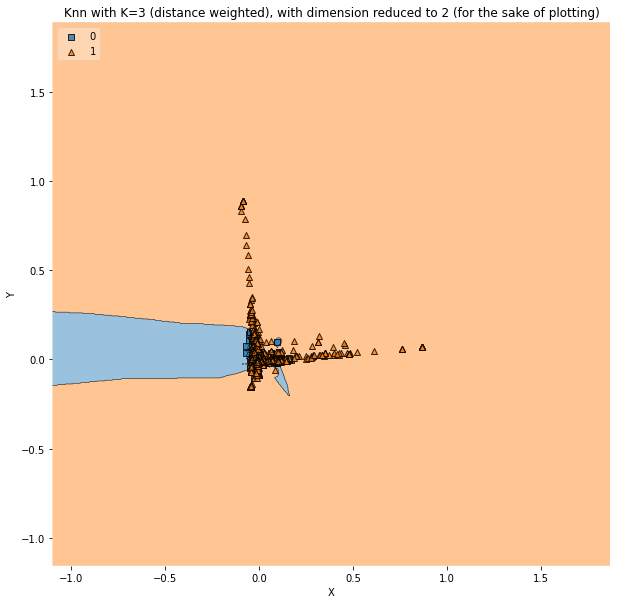

'HYPER PARAMETER TUNING (not used, performance issues)\n\n# Train test split\n#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)\n\n# # Grid Search - hyperparameters tuning\ngrid = {\'n_neighbors\':np.arange(1,100),\n        \'p\':np.arange(1,3),\n        \'weights\':[\'uniform\',\'distance\']\n       }\n\n# Define and fit model\nknn = KNeighborsClassifier()\nknn_cv = GridSearchCV(knn, grid, cv=10)\nknn_cv.fit(X_train_norm, y_train)\n\n# Print results\nprint("Hyperparameters:", knn_cv.best_params_)\nprint("Train Score:", round(knn_cv.best_score_, 4))\nprint("Test Score:", round(knn_cv.score(X_test_norm, y_test), 4))'

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# < k-NEAREST-NEIGHBOURG/S >, for texts

# Copy of dataframe

df_knn = preprocess(df)
df_knn = df_knn.drop(['id','keyword','location'], axis=1)

# Define vectorizer, vectorize tokens and initialize a dataframe 
# combining them with the target value for each document (tweet)

tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', 
                        ngram_range=(1, 1), tokenizer=spacy_token)
matrix = tfidf.fit_transform(df_knn['text']).todense()
columns = tfidf.get_feature_names()
print(columns)
target = df_knn['target']
df_knn = pd.concat([target, pd.DataFrame(X,columns = [columns])], axis=1)

print(df_knn)

# Initialize the variables, then fit the model
X = df_knn.drop(["target"], axis=1)
y = df_knn["target"]


# KNN plot
fig, ax = plt.subplots(1, figsize=(10,10))

model = KNeighborsClassifier(n_neighbors=3,weights = 'distance').fit(matrix,y)
#pred = model.predict(X)
print("*** THE SCORE (on training set) IS :",model.score(matrix, y))

# Plotting decision region
# Reduce dimensionality of the dataset to 2 components
pca = PCA(n_components = 2)
X_train = pca.fit_transform(matrix)

model = KNeighborsClassifier(n_neighbors=3,weights = 'distance').fit(X_train,y)

y = y.to_numpy()
plot_decision_regions(X_train, y, clf=model, legend=2)
# Adding axes annotations
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Knn with K='+ str(3)+' (distance weighted), with dimension reduced to 2 (for the sake of plotting)')
plt.show()

"""HYPER PARAMETER TUNING (not used, performance issues)

# Train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

# # Grid Search - hyperparameters tuning
grid = {'n_neighbors':np.arange(1,100),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)
knn_cv.fit(X_train_norm, y_train)

# Print results
print("Hyperparameters:", knn_cv.best_params_)
print("Train Score:", round(knn_cv.best_score_, 4))
print("Test Score:", round(knn_cv.score(X_test_norm, y_test), 4))"""


###6.4 **Decision Tree classifier, with TF-IDF words vectorization (on texts and, optionally, keywords)**

['0', '0011', '001116', '0025', '005225', '010217', '0104', '010401', '0106', '0111', '012032', '012624', '015025', '02', '0215', '03', '0306', '0308', '030811', '034', '0400', '045', '05', '05082015', '05th', '06', '0605', '061', '063243', '063424', '06jst', '07', '070', '0700', '0730', '075', '080', '0800', '0802pm', '080515', '080615', '08062015', '08072015', '08315', '0840728', '09', '0913', '0936', '0day', '0npzp', '1', '10', '100', '1000', '10000', '100000', '1000amp1000', '1000s', '1008pla', '1008planet', '100bn', '100nd', '101', '1015', '1015pm', '1028', '103', '1030', '1030pm', '103424', '1038pm', '10401', '1040pm', '105', '1061', '1061thetwister', '10638', '1079', '109', '10monthold', '10news', '10th', '10w', '10x', '11', '1100', '110358', '111020', '112', '1130', '1130a', '1130bst', '11382', '114', '1145', '115', '115film', '118', '11st', '11yearold', '12', '1200', '12000', '120000', '12007', '1211', '1236', '124', '1241317240', '125', '129', '12hr', '12jst', '12news', '12st

[Text(993.5402735341893, 1062.490909090909, 'X[2328] <= 0.182\ngini = 0.49\nsamples = 5176\nvalue = [2958, 2218]'),
 Text(915.2785668703589, 1013.0727272727273, 'X[7008] <= 0.167\ngini = 0.487\nsamples = 5095\nvalue = [2954, 2141]'),
 Text(825.0521832456683, 963.6545454545455, 'X[5926] <= 0.088\ngini = 0.484\nsamples = 4994\nvalue = [2943, 2051]'),
 Text(814.0026782951732, 914.2363636363636, 'X[8046] <= 0.108\ngini = 0.482\nsamples = 4937\nvalue = [2943, 1994]'),
 Text(802.9531733446781, 864.8181818181819, 'X[4843] <= 0.063\ngini = 0.479\nsamples = 4888\nvalue = [2943, 1945]'),
 Text(710.8964456992574, 815.4000000000001, 'X[12588] <= 0.225\ngini = 0.474\nsamples = 4684\nvalue = [2875, 1809]'),
 Text(626.2285349628712, 765.9818181818182, 'X[11880] <= 0.082\ngini = 0.471\nsamples = 4624\nvalue = [2869, 1755]'),
 Text(523.1897431930693, 716.5636363636363, 'X[13267] <= 0.092\ngini = 0.468\nsamples = 4576\nvalue = [2864, 1712]'),
 Text(512.1402382425742, 667.1454545454546, 'X[3822] <= 0.083

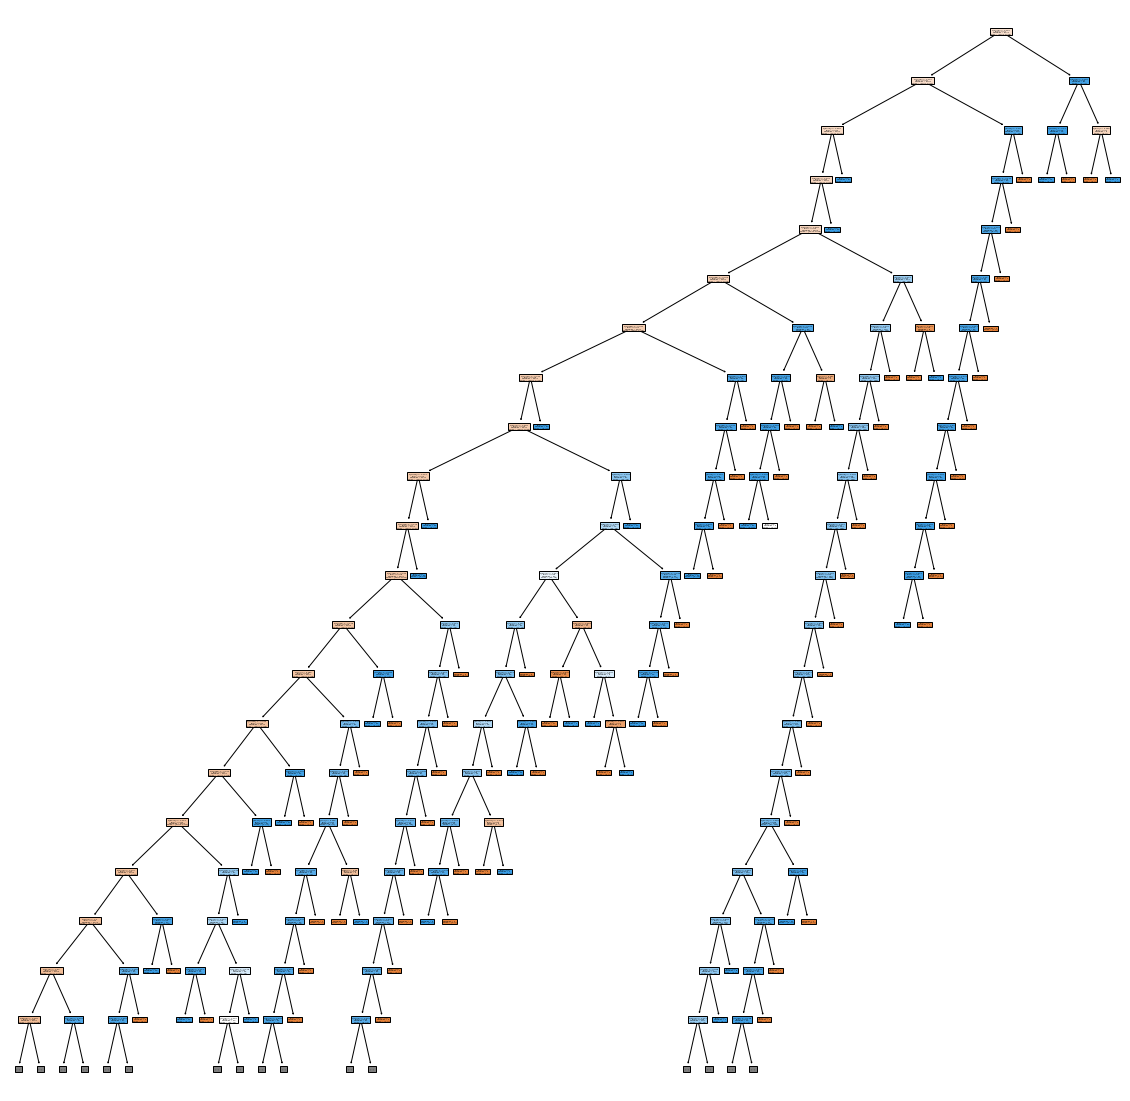

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

#-----------------------------------<TEXTS>-------------------------------------

# Copy of dataframe

df_tree = df
df_tree = df.drop(['id','keyword','location'], axis=1)

# Define vectorizer, vectorize tokens and initialize a dataframe 
# combining them with the target value for each document (tweet)

tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', 
                        ngram_range=(1, 1), tokenizer=spacy_token)
X = tfidf.fit_transform(df_tree['text']).todense()
columns = tfidf.get_feature_names()
print(columns)
target = df_tree['target']
df_tree = pd.concat([target, pd.DataFrame(X,columns = [columns])], axis=1)

print(df_tree)

#Initialize the variables, then fit the model

X = df_tree.drop(["target"], axis=1)
y = df_tree["target"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#HYPER PARAMETER TUNING
grid = {'criterion':['gini','entropy'],
        'max_depth':[100,150],
       }

# Define and fit model
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, grid, cv=10)
tree_cv.fit(X_train, y_train)

# Print results
print("Hyperparameters:", tree_cv.best_params_)
print("Train Score:", round(tree_cv.best_score_, 4))
print("Test Score:", round(tree_cv.score(X_test, y_test), 4))


tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 100)
tree.fit(X_train, y_train)

print("*** THE SCORE (on training set) IS :",tree.score(X_train, y_train))
print("*** THE TREE DEPTH IS :",tree.get_depth())

plt.figure(figsize=(20,20))
plot_tree(tree, max_depth = 20,filled=True)


      (ablaze,)  (accident,)  (aftershock,)  ...  (wreckage,)  (wrecked,)  target
0           0.0          0.0            0.0  ...          0.0         0.0       0
1           0.0          0.0            0.0  ...          0.0         0.0       0
2           0.0          0.0            0.0  ...          0.0         0.0       1
3           0.0          0.0            0.0  ...          0.0         0.0       1
4           0.0          0.0            0.0  ...          0.0         0.0       1
...         ...          ...            ...  ...          ...         ...     ...
6466        0.0          0.0            0.0  ...          0.0         0.0       1
6467        0.0          0.0            0.0  ...          0.0         0.0       0
6468        0.0          0.0            0.0  ...          0.0         0.0       1
6469        0.0          0.0            0.0  ...          0.0         0.0       1
6470        0.0          0.0            0.0  ...          0.0         0.0       1

[6471 rows x 22

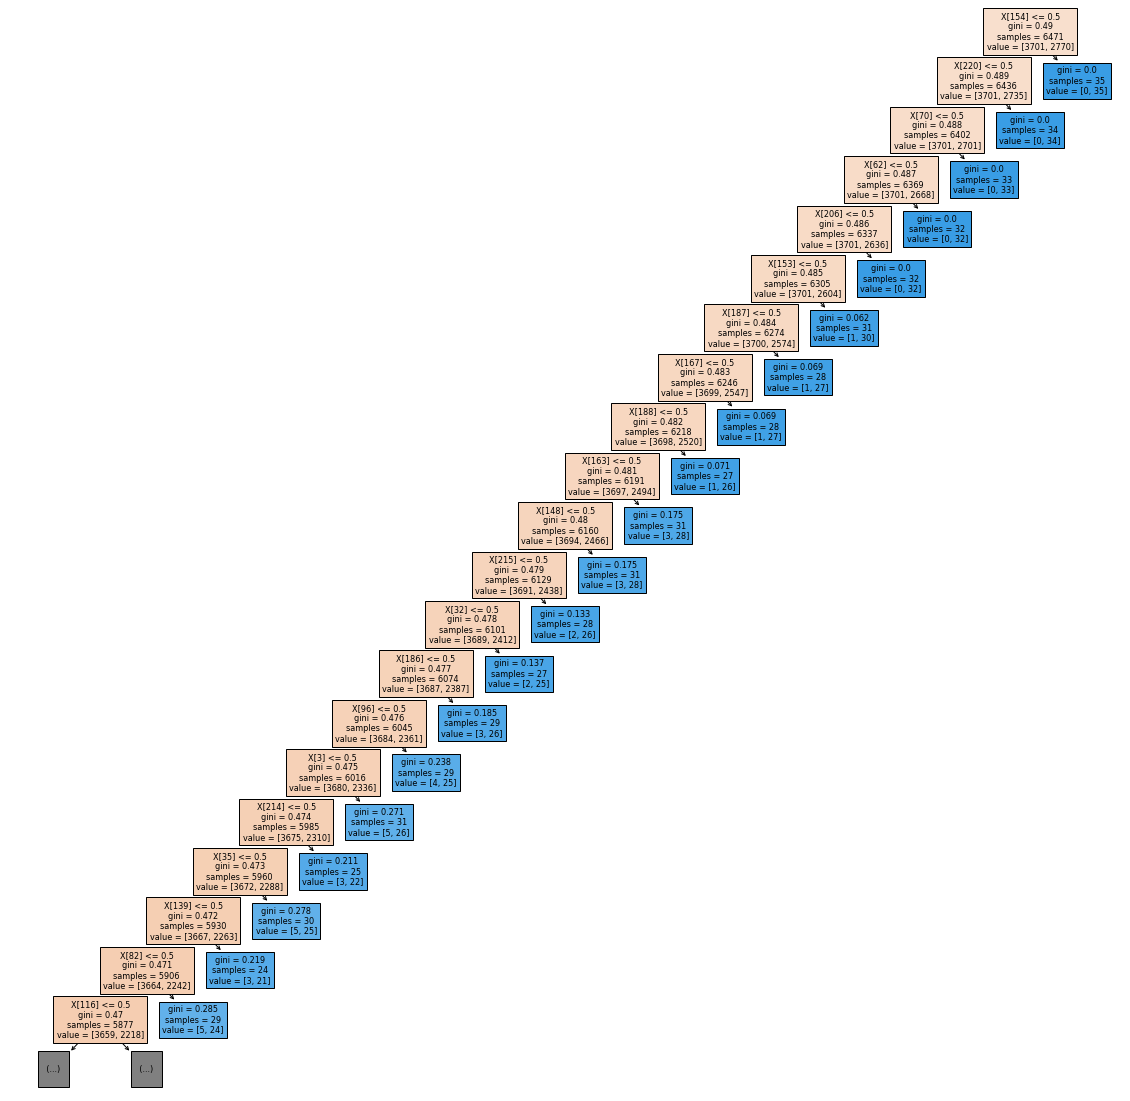

In [ ]:

#---------------------------------<KEYWORDS>------------------------------------

# Copy of dataframe

df_tree = preprocess(df)
df_tree = df.drop(['id','text','location'], axis=1)

# One hot encoding of the keywords for each document (tweet), combining
# the keywords encoded with the target value

one_hot = OneHotEncoder()

key_to_onehot = one_hot.fit_transform(df_tree[["keyword"]]).toarray()
key_to_onehot = pd.DataFrame(key_to_onehot, columns=one_hot.categories_)

df_tree = pd.concat([key_to_onehot,df_tree['target']],axis = 1)
print(df_tree)

# Initialize the variables, then fit the model

X = df_tree.drop(["target"], axis=1)
y = df_tree["target"]

tree = DecisionTreeClassifier()
tree.fit(X, y)
print("*** THE SCORE (on training set) IS :",tree.score(X, y))
print("*** THE TREE DEPTH IS :",tree.get_depth())
plt.figure(figsize=(20,20))
plot_tree(tree, max_depth = 20,filled=True)
print("*** THE DECISION TREE (texts,keywords) ARE :")